In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time

from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('data/merged_table.csv')
df.head()

,transcaction_id,date,company,city,km,price,cost,profit,customer_id,gender,age,payment_mode,monthly_income
0,10000011,2016-01-08,Pink Cab,ATLANTA GA,30.45,370.95,313.635,57.315,29290,Male,28,Card,10813
1,10000012,2016-01-06,Pink Cab,ATLANTA GA,28.62,358.52,334.854,23.666,27703,Male,27,Card,9237
2,10000013,2016-01-02,Pink Cab,ATLANTA GA,9.04,125.20,97.632,27.568,28712,Male,53,Cash,11242
3,10000014,2016-01-07,Pink Cab,ATLANTA GA,33.17,377.40,351.602,25.798,28020,Male,23,Cash,23327
4,10000015,2016-01-03,Pink Cab,ATLANTA GA,8.73,114.62,97.776,16.844,27182,Male,33,Card,8536


In [5]:
# convert date in pandas
df['date'] = pd.to_datetime(df['date'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   transcaction_id  359392 non-null  int64         
 1   date             359392 non-null  datetime64[ns]
 2   company          359392 non-null  object        
 3   city             359392 non-null  object        
 4   km               359392 non-null  float64       
 5   price            359392 non-null  float64       
 6   cost             359392 non-null  float64       
 7   profit           359392 non-null  float64       
 8   customer_id      359392 non-null  int64         
 9   gender           359392 non-null  object        
 10  age              359392 non-null  int64         
 11  payment_mode     359392 non-null  object        
 12  monthly_income   359392 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(4), object(4)
memory usage: 35.6+ 

In [9]:
time_series = df[['company', 'date', 'profit']]
time_series.head()

,company,date,profit
0,Pink Cab,2016-01-08,57.315
1,Pink Cab,2016-01-06,23.666
2,Pink Cab,2016-01-02,27.568
3,Pink Cab,2016-01-07,25.798
4,Pink Cab,2016-01-03,16.844


In [10]:
time_series['company'].value_counts()

company
Yellow Cab    274681
Pink Cab       84711
Name: count, dtype: int64

In [19]:
# create two filter of Pink Cab and Yellow Cab 
pink_cab_filt = (time_series['company'] == 'Pink Cab')
yellow_cab_filt = (time_series['company'] == 'Yellow Cab')

pink_cab = time_series[pink_cab_filt][['date', 'profit']]
yellow_cab = time_series[yellow_cab_filt][['date', 'profit']]

In [21]:
pink_cab.set_index('date', inplace=True)
yellow_cab.set_index('date',inplace=True)

In [24]:
pink_cab

,profit
date,
2016-01-08,57.315
2016-01-06,23.666
2016-01-02,27.568
2016-01-07,25.798
2016-01-03,16.844
...,...
2018-01-06,48.590
2018-12-31,85.344
2018-01-07,58.390


In [45]:
pink_cab = pink_cab.groupby('date')['profit'].sum()


pandas.core.series.Series

In [60]:
pink_cab = pink_cab.resample('M').sum()

In [61]:
pink_cab.head()

date
2016-01-31    73952.863
2016-02-29    87475.544
2016-03-31    87801.183
2016-04-30    82591.853
2016-05-31    61550.958
Freq: M, Name: profit, dtype: float64

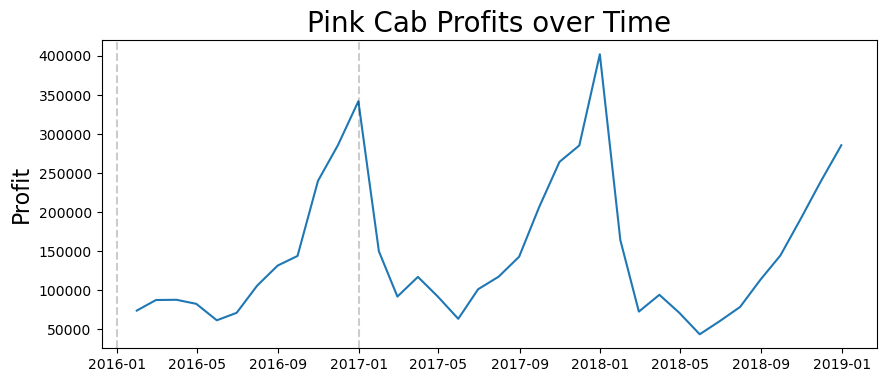

In [95]:
plt.figure(figsize=(10,4))
plt.plot(pink_cab)
plt.title('Pink Cab Profits over Time', fontsize=20)
plt.ylabel('Profit', fontsize=16)
for year in range(pink_cab.index.min().year, pink_cab.index.max().year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

The data is not stationary, I should convert that first

In [141]:
log_profit = np.log(pink_cab)

In [142]:
first_diff = log_profit.diff()[1:]

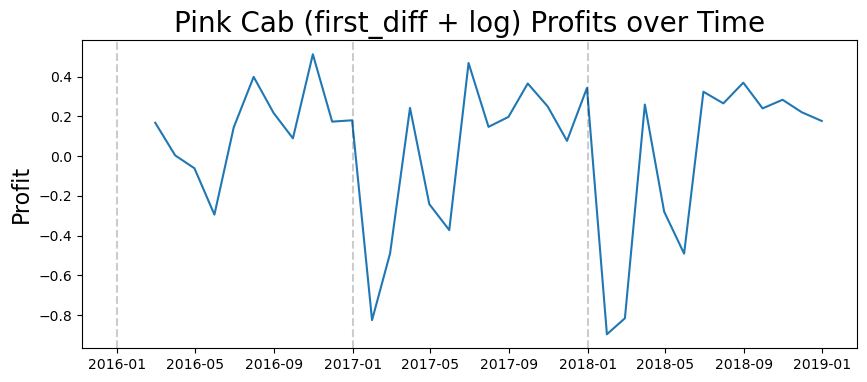

In [163]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Pink Cab (first_diff + log) Profits over Time', fontsize=20)
plt.ylabel('Profit', fontsize=16)
for year in range(pink_cab.index.min().year, pink_cab.index.max().year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [144]:
# use ADF test to determine stationarity
pink_result = adfuller(first_diff)
print('ADF Statistic: %f' % pink_result[0])
print('p-value: %f' % pink_result[1])

ADF Statistic: -5.503964
p-value: 0.000002


## Plot ACF and PACF

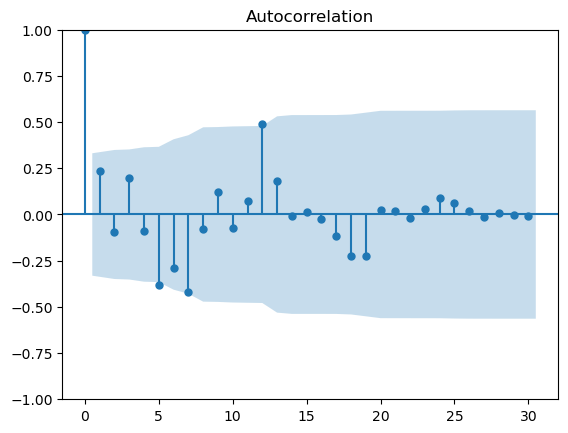

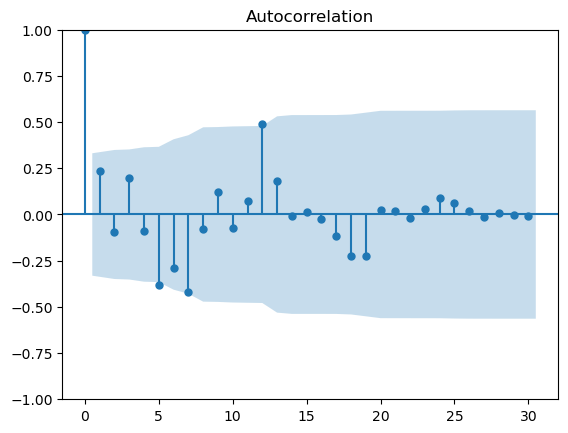

In [147]:
# ACF
plot_acf(first_diff, lags=30)

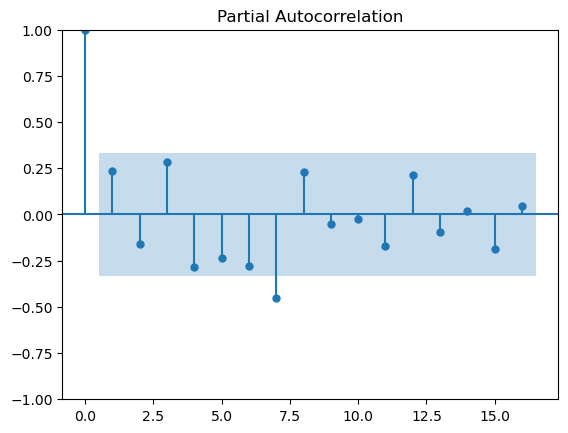

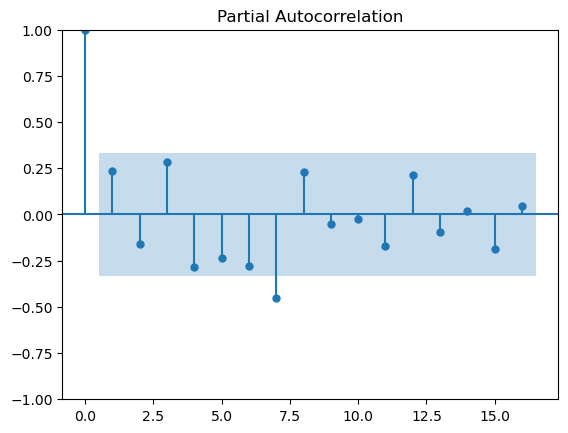

In [148]:
# Plot the PACF
plot_pacf(first_diff, lags=16)


We can see that only seasonal pattern is captured. we should start with seasonal MA and AR process

In [149]:
# Split the data into training and test sets
train = pink_cab[:'2018-06-30']
test = pink_cab['2018-07-01':]

In [150]:
test

date
2018-07-31     78623.979
2018-08-31    113753.922
2018-09-30    144622.939
2018-10-31    191993.974
2018-11-30    239337.731
2018-12-31    285605.927
Freq: M, Name: profit, dtype: float64

## Fit the SARIMA Model

In [151]:
my_order = (0,1,0)
my_seasonal_order = (1,0,0,12)

model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)

In [152]:
model_fit = model.fit()

c:\Users\felix\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


In [153]:
#summary of the model
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             profit   No. Observations:                   30
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -362.261
Date:                            Wed, 10 Jan 2024   AIC                            728.521
Time:                                    11:20:41   BIC                            731.256
Sample:                                01-31-2016   HQIC                           729.378
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.5228      0.112      4.686      0.000       0.304       0.741
sigma2      3.674e+09   4.93e-12   

In [154]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions

Text(0, 0.5, 'Error')

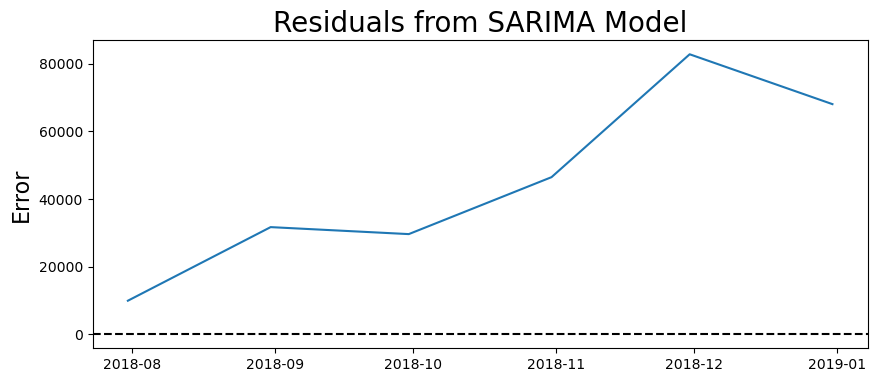

In [155]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

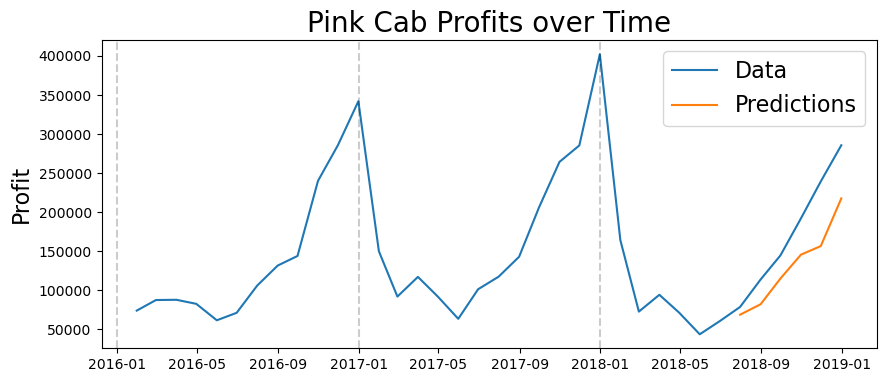

In [156]:
plt.figure(figsize=(10,4))

plt.plot(pink_cab)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pink Cab Profits over Time', fontsize=20)
plt.ylabel('Profit', fontsize=16)
for year in range(pink_cab.index.min().year, pink_cab.index.max().year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [157]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test)),4))

Mean Absolute Percent Error: 0.2393


In [158]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 51022.77327197102


### Using the Rolling Forecast Origin

In [159]:
rolling_predictions = test.copy()
for train_end in test.index:
    train_data = pink_cab[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

c:\Users\felix\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\felix\AppData\Local\Temp\ipykernel_21520\3143698550.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
c:\Users\felix\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\felix\AppData\Local\Temp\ipykernel_21520\3143698550.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
c:\Users\felix\anaco

In [160]:
rolling_residuals = test - rolling_predictions

Text(0, 0.5, 'Error')

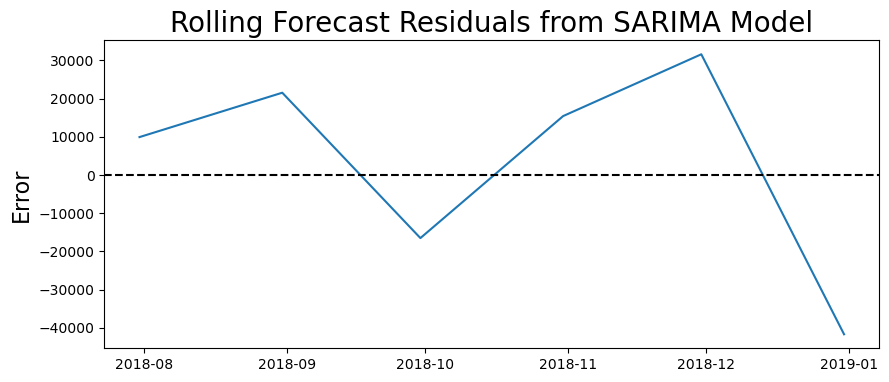

In [161]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

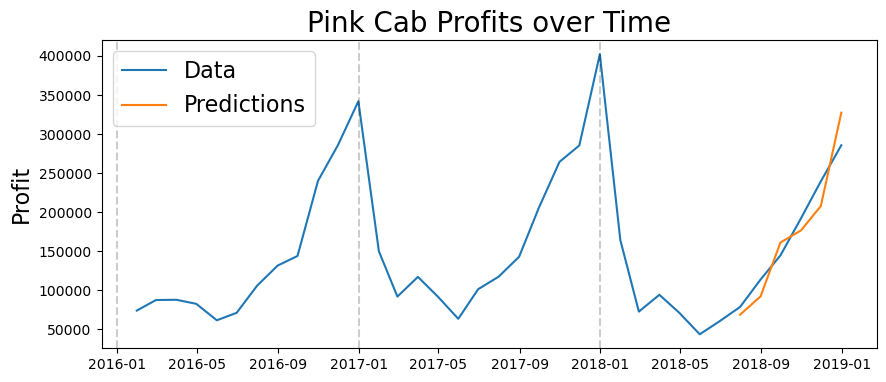

In [162]:
plt.figure(figsize=(10,4))

plt.plot(pink_cab)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pink Cab Profits over Time', fontsize=20)
plt.ylabel('Profit', fontsize=16)
for year in range(pink_cab.index.min().year, pink_cab.index.max().year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [129]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test)),4))

Mean Absolute Percent Error: 0.1478


In [130]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 27080.768033907236


## Pink cab prediction in 2019

In [165]:
# Generate a date range of the last day of each month from January to June 2019
date_range = pd.date_range(start='2019-01-01', end='2019-06-30', freq='M')

# Since date_range gives the last day of each month, no further formatting is needed for the end of the month
date_series = pd.Series(date_range)

date_series

0   2019-01-31
1   2019-02-28
2   2019-03-31
3   2019-04-30
4   2019-05-31
5   2019-06-30
dtype: datetime64[ns]

In [208]:
series2 = pd.Series([0.0]*6)

# Create DataFrame directly
pred_table = pd.DataFrame({'date': date_series, 'profit': series2})

pred_table.set_index('date', inplace=True)

pred_table = pred_table['profit'].squeeze()

pred_table.index = pd.to_datetime(pred_table.index).to_period('M').to_timestamp()

pred_table

date
2019-01-01    0.0
2019-02-01    0.0
2019-03-01    0.0
2019-04-01    0.0
2019-05-01    0.0
2019-06-01    0.0
Freq: MS, Name: profit, dtype: float64

In [224]:
pink_cab.index = pd.to_datetime(pink_cab.index).to_period('M').to_timestamp()
pink_cab.head()

date
2016-01-01    73952.863
2016-02-01    87475.544
2016-03-01    87801.183
2016-04-01    82591.853
2016-05-01    61550.958
Freq: MS, Name: profit, dtype: float64

In [226]:
# Now concatenate them along the axis=1 (column-wise)
training = pd.concat([pink_cab, pred_table], axis=0)
# Assuming 'training' is your DataFrame or Series.
training.index = pd.to_datetime(training.index).to_period('M').to_timestamp()
training

date
2016-01-01     73952.863
2016-02-01     87475.544
2016-03-01     87801.183
2016-04-01     82591.853
2016-05-01     61550.958
2016-06-01     71103.252
2016-07-01    105912.738
2016-08-01    131573.364
2016-09-01    143889.421
2016-10-01    240114.858
2016-11-01    285591.891
2016-12-01    341953.299
2017-01-01    149917.004
2017-02-01     91900.701
2017-03-01    117105.300
2017-04-01     91987.847
2017-05-01     63429.024
2017-06-01    101300.478
2017-07-01    117348.380
2017-08-01    142924.014
2017-09-01    205922.965
2017-10-01    264328.239
2017-11-01    285396.550
2017-12-01    402094.406
2018-01-01    164184.735
2018-02-01     72665.064
2018-03-01     94190.088
2018-04-01     71238.395
2018-05-01     43633.932
2018-06-01     60311.503
2018-07-01     78623.979
2018-08-01    113753.922
2018-09-01    144622.939
2018-10-01    191993.974
2018-11-01    239337.731
2018-12-01    285605.927
2019-01-01         0.000
2019-02-01         0.000
2019-03-01         0.000
2019-04-01         0

In [229]:

# Assuming pink_cab is your training data up to a certain point and pred_table is all zeros to be filled
training_data = training.copy()
rolling_predictions = pred_table.copy()

# Define the model orders
my_order = (0, 1, 0)
my_seasonal_order = (1, 0, 0, 12)

# Perform rolling predictions
for train_end in pred_table.index:
    # Use data up to the current point to train the model
    train_data = training_data[:train_end - pd.Timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit(disp=False)  # disp=False will prevent printing of convergence messages

    # Forecast the next point
    pred = model_fit.forecast()
    
    # Update the rolling predictions Series and training data with the new prediction
    rolling_predictions[train_end] = pred.iloc[0]
    training_data[train_end] = pred.iloc[0]  # This assumes you want to include predictions as part of the training data for the next round


In [230]:
rolling_predictions

date
2019-01-01    119268.140682
2019-02-01     64522.965306
2019-03-01     77830.328196
2019-04-01     61865.192975
2019-05-01     42580.156289
2019-06-01     54278.310904
Freq: MS, Name: profit, dtype: float64

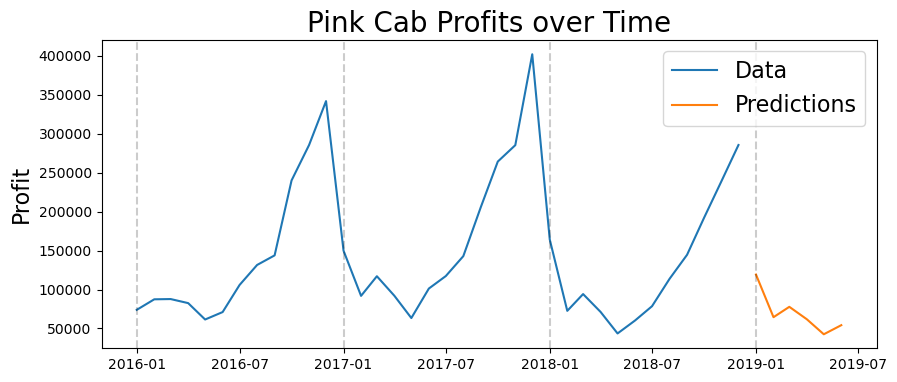

In [233]:
plt.figure(figsize=(10,4))

plt.plot(pink_cab)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Pink Cab Profits over Time', fontsize=20)
plt.ylabel('Profit', fontsize=16)
for year in range(pink_cab.index.min().year, pink_cab.index.max().year+2):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

# Yello Cab

In [236]:
yellow_cab

,profit
date,
2016-01-02,877.0076
2016-01-09,895.7768
2016-01-03,232.3320
2016-01-06,504.1600
2016-01-07,944.1908
...,...
2018-01-08,5.8800
2018-01-04,6.9020
2018-01-05,87.4200


In [ ]:
yellow_cab = yellow_cab.groupby('date')['profit'].sum()

yellow_cab = yellow_cab.resample('M').sum()


In [239]:
yellow_cab.index = pd.to_datetime(yellow_cab.index).to_period('M').to_timestamp()

yellow_cab.head()

date
2016-01-01    8.363081e+05
2016-02-01    1.009169e+06
2016-03-01    9.147648e+05
2016-04-01    9.461364e+05
2016-05-01    1.282773e+06
Freq: MS, Name: profit, dtype: float64

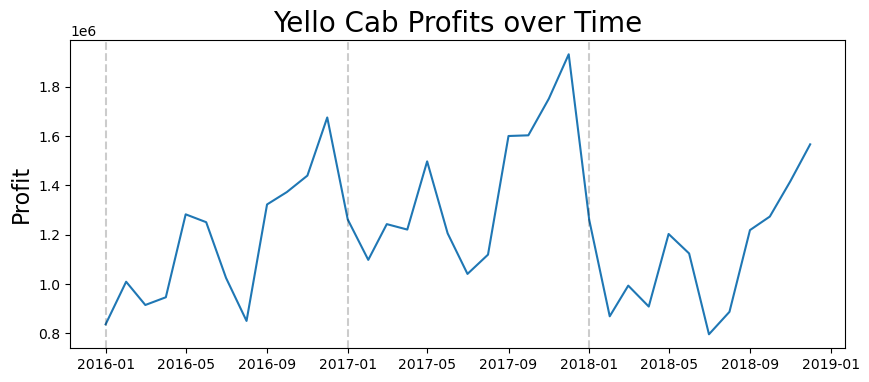

In [242]:
# Plot yellow cab

plt.figure(figsize=(10,4))
plt.plot(yellow_cab)
plt.title('Yello Cab Profits over Time', fontsize=20)
plt.ylabel('Profit', fontsize=16)
for year in range(yellow_cab.index.min().year, yellow_cab.index.max().year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [243]:
## convert to stationary

In [254]:
# log_profit = np.log(yellow_cab)
first_diff = yellow_cab.diff()[1:]

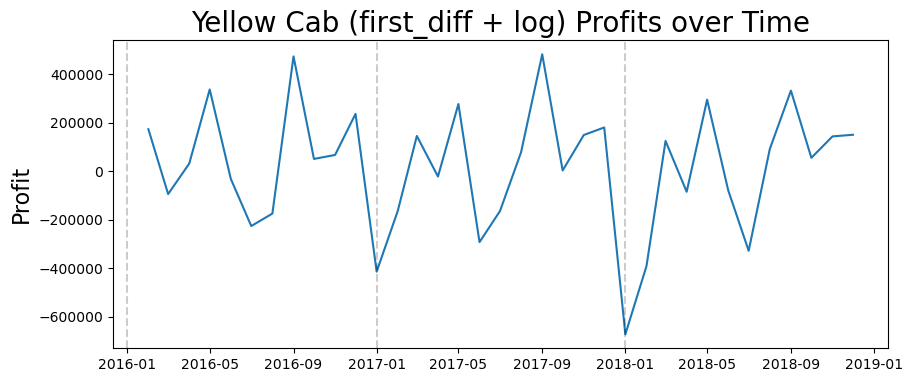

In [255]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Yellow Cab (first_diff + log) Profits over Time', fontsize=20)
plt.ylabel('Profit', fontsize=16)
for year in range(pink_cab.index.min().year, pink_cab.index.max().year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [256]:
# use ADF test to determine stationarity
pink_result = adfuller(first_diff)
print('ADF Statistic: %f' % pink_result[0])
print('p-value: %f' % pink_result[1])

ADF Statistic: -4.560784
p-value: 0.000152


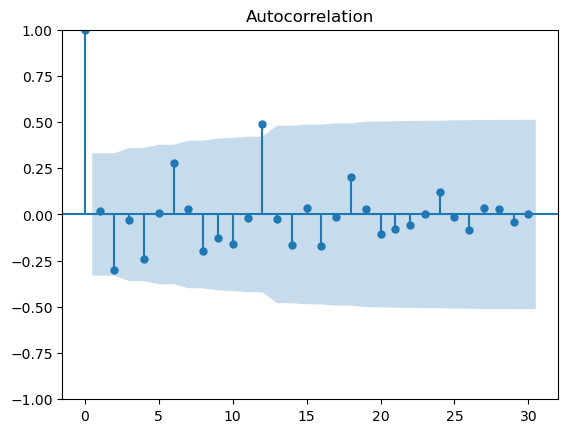

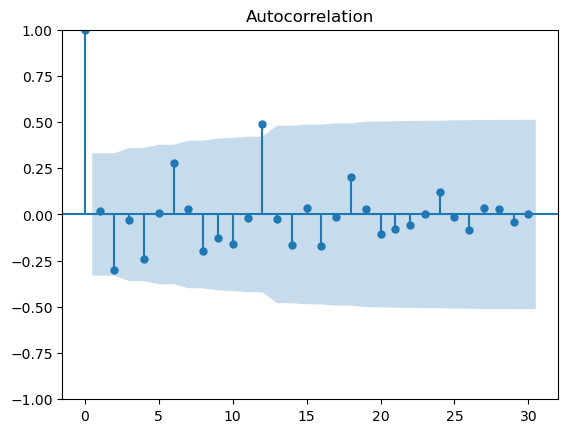

In [257]:
# ACF
plot_acf(first_diff, lags=30)


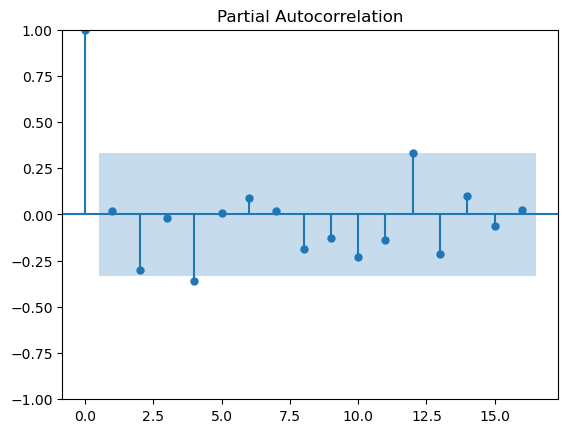

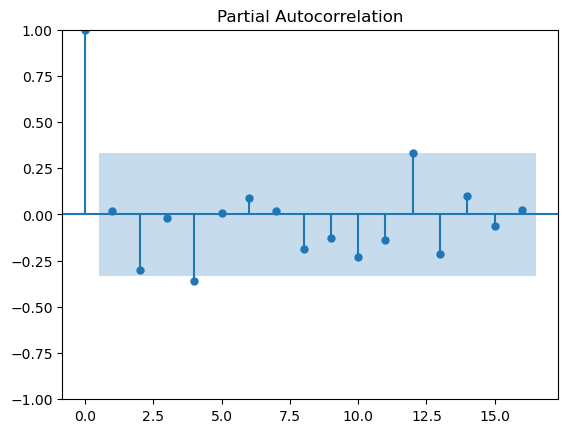

In [258]:
# Plot the PACF
plot_pacf(first_diff, lags=16)

In [259]:
##################

In [263]:
# Split the data into training and test sets
train = yellow_cab[:'2018-06-30']
test = yellow_cab['2018-07-01':]

In [265]:
test

date
2018-07-01    7.959062e+05
2018-08-01    8.869987e+05
2018-09-01    1.218804e+06
2018-10-01    1.273756e+06
2018-11-01    1.416933e+06
2018-12-01    1.566886e+06
Freq: MS, Name: profit, dtype: float64

## Modelling

In [269]:
my_order = (0,1,0)
my_seasonal_order = (1,0,0,12)

model = SARIMAX(train, order=my_order, seasonal_order=my_seasonal_order)

In [270]:
model_fit = model.fit()

In [271]:
#summary of the model
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             profit   No. Observations:                   30
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -406.816
Date:                            Wed, 10 Jan 2024   AIC                            817.631
Time:                                    12:45:41   BIC                            820.366
Sample:                                01-01-2016   HQIC                           818.488
                                     - 06-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.3370      0.044      7.697      0.000       0.251       0.423
sigma2      2.867e+10   3.19e-13   

In [272]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test))
predictions = pd.Series(predictions, index=test.index)
residuals = test - predictions

Text(0, 0.5, 'Error')

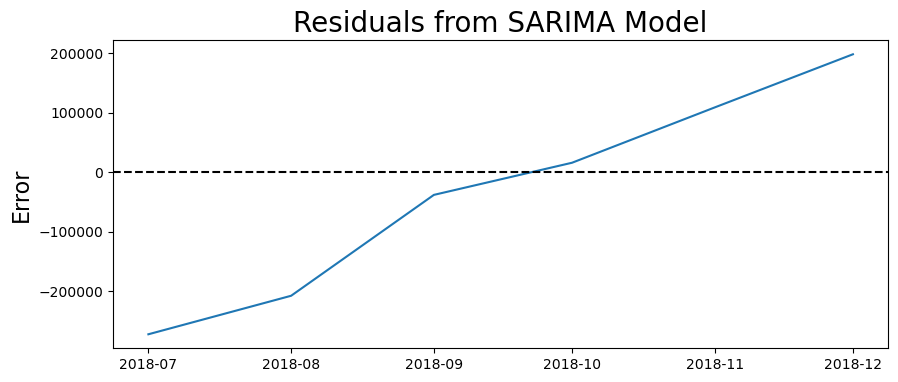

In [273]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)



### Use rolling forcast

In [274]:
rolling_predictions = test.copy()
for train_end in test.index:
    train_data = yellow_cab[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

C:\Users\felix\AppData\Local\Temp\ipykernel_21520\1586850457.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
C:\Users\felix\AppData\Local\Temp\ipykernel_21520\1586850457.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
C:\Users\felix\AppData\Local\Temp\ipykernel_21520\1586850457.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
C:\Users\felix\AppData\Local\Temp\ipykernel_21520\1586850457.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred


In [275]:
rolling_residuals = test - rolling_predictions

Text(0, 0.5, 'Error')

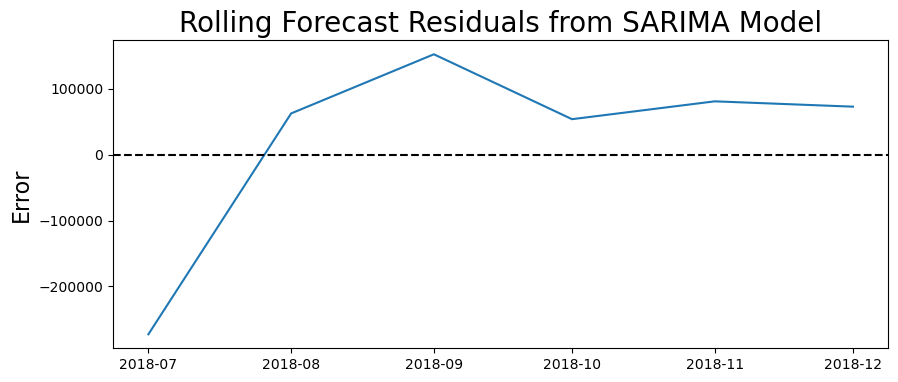

In [276]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)


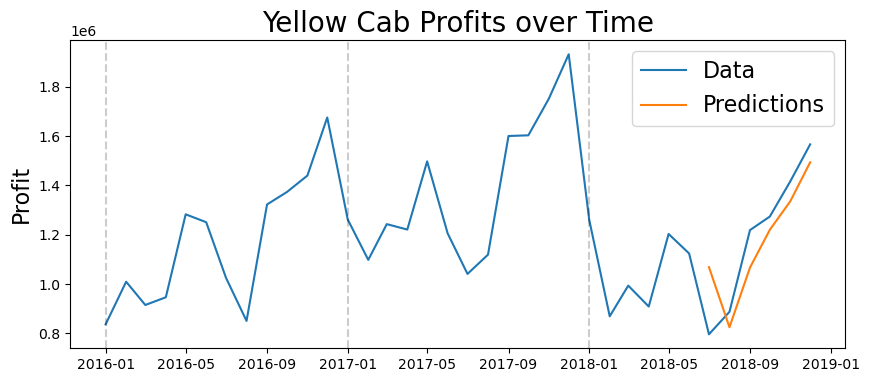

In [277]:
plt.figure(figsize=(10,4))

plt.plot(yellow_cab)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Yellow Cab Profits over Time', fontsize=20)
plt.ylabel('Profit', fontsize=16)
for year in range(yellow_cab.index.min().year, yellow_cab.index.max().year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [278]:

print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test)),4))

print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Mean Absolute Percent Error: 0.1139
Root Mean Squared Error: 139107.73994855164


## Yellow cab prediction in 2019

In [279]:
# Generate a date range of the last day of each month from January to June 2019
date_range = pd.date_range(start='2019-01-01', end='2019-06-30', freq='M')

# Since date_range gives the last day of each month, no further formatting is needed for the end of the month
date_series = pd.Series(date_range)

date_series

0   2019-01-31
1   2019-02-28
2   2019-03-31
3   2019-04-30
4   2019-05-31
5   2019-06-30
dtype: datetime64[ns]

In [280]:
series2 = pd.Series([0.0]*6)

# Create DataFrame directly
pred_table = pd.DataFrame({'date': date_series, 'profit': series2})

pred_table.set_index('date', inplace=True)

pred_table = pred_table['profit'].squeeze()

pred_table.index = pd.to_datetime(pred_table.index).to_period('M').to_timestamp()

pred_table

date
2019-01-01    0.0
2019-02-01    0.0
2019-03-01    0.0
2019-04-01    0.0
2019-05-01    0.0
2019-06-01    0.0
Freq: MS, Name: profit, dtype: float64

In [281]:
# Now concatenate them along the axis=1 (column-wise)
training = pd.concat([yellow_cab, pred_table], axis=0)
# Assuming 'training' is your DataFrame or Series.
training.index = pd.to_datetime(training.index).to_period('M').to_timestamp()
training


date
2016-01-01    8.363081e+05
2016-02-01    1.009169e+06
2016-03-01    9.147648e+05
2016-04-01    9.461364e+05
2016-05-01    1.282773e+06
2016-06-01    1.250892e+06
2016-07-01    1.024755e+06
2016-08-01    8.501200e+05
2016-09-01    1.322873e+06
2016-10-01    1.373259e+06
2016-11-01    1.440007e+06
2016-12-01    1.675938e+06
2017-01-01    1.261753e+06
2017-02-01    1.097925e+06
2017-03-01    1.243013e+06
2017-04-01    1.220955e+06
2017-05-01    1.497737e+06
2017-06-01    1.205511e+06
2017-07-01    1.040901e+06
2017-08-01    1.119152e+06
2017-09-01    1.600706e+06
2017-10-01    1.603497e+06
2017-11-01    1.752381e+06
2017-12-01    1.932446e+06
2018-01-01    1.260374e+06
2018-02-01    8.688848e+05
2018-03-01    9.934367e+05
2018-04-01    9.084510e+05
2018-05-01    1.203033e+06
2018-06-01    1.123935e+06
2018-07-01    7.959062e+05
2018-08-01    8.869987e+05
2018-09-01    1.218804e+06
2018-10-01    1.273756e+06
2018-11-01    1.416933e+06
2018-12-01    1.566886e+06
2019-01-01    0.000000e

In [282]:
# Assuming pink_cab is your training data up to a certain point and pred_table is all zeros to be filled
training_data = training.copy()
rolling_predictions = pred_table.copy()

# Define the model orders
my_order = (0, 1, 0)
my_seasonal_order = (1, 0, 0, 12)

# Perform rolling predictions
for train_end in pred_table.index:
    # Use data up to the current point to train the model
    train_data = training_data[:train_end - pd.Timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit(disp=False)  # disp=False will prevent printing of convergence messages

    # Forecast the next point
    pred = model_fit.forecast()
    
    # Update the rolling predictions Series and training data with the new prediction
    rolling_predictions[train_end] = pred.iloc[0]
    training_data[train_end] = pred.iloc[0]  # This assumes you want to include predictions as part of the training data for the next round


In [283]:
rolling_predictions

date
2019-01-01    1.271921e+06
2019-02-01    1.102033e+06
2019-03-01    1.156186e+06
2019-04-01    1.119055e+06
2019-05-01    1.248365e+06
2019-06-01    1.213543e+06
Freq: MS, Name: profit, dtype: float64

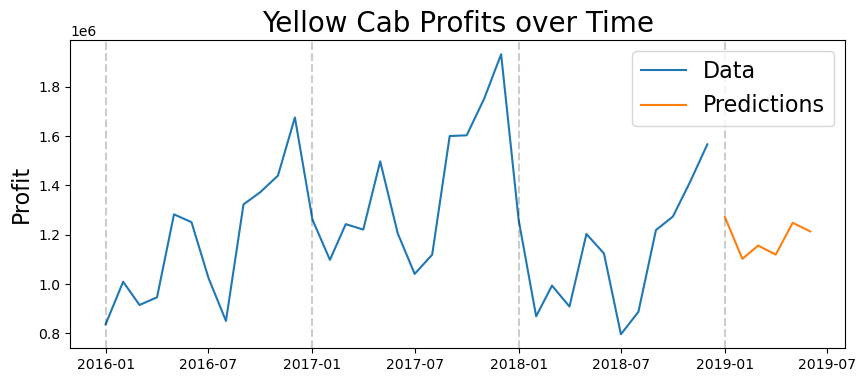

In [284]:
plt.figure(figsize=(10,4))

plt.plot(yellow_cab)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Yellow Cab Profits over Time', fontsize=20)
plt.ylabel('Profit', fontsize=16)
for year in range(yellow_cab.index.min().year, yellow_cab.index.max().year+2):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)